## Impact of denoising as one increases


In [1]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scprint.tasks import Denoiser, withknn
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint_v2


In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../../../w937u4o1.ckpt"
# w937u4o1

In [5]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)


label decoders have changed, be careful
FYI: scPrint is not attached to a `Trainer`.


In [6]:
model = model.to('cuda')

# run denoising as depth increase

In [ ]:
import lamindb as ln

res = ln.Artifact.filter(uid="vhwQPOwZ3kyGtOv00001")[0]
print(res.key)
print(res.path)
print()
res = ln.Artifact.filter(uid="Q1fKksCKtOAgigiT0001")[0]
print(res.key)
print(res.path)

# 2025-02-25/h5ad/Velocyto/Homo_sapiens/SRX24486462.h5ad
# /pasteur/appa/scratch/jkalfon/scprint2/.lamindb/vhwQPOwZ3kyGtOv00001.h5ad

# 2025-02-25/h5ad/Velocyto/Homo_sapiens/SRX22526970.h5ad
# /pasteur/appa/scratch/jkalfon/scprint2/.lamindb/Q1fKksCKtOAgigiT0001.h5ad

In [7]:
LOC = "../../data/temp/"  #

datasets = {
    "retina": "https://datasets.cellxgene.cziscience.com/53bd4177-79c6-40c8-b84d-ff300dcf1b5b.h5ad",  # gNNpgpo6gATjuxTE7CCp
    "kidney": "https://datasets.cellxgene.cziscience.com/01bc7039-961f-4c24-b407-d535a2a7ba2c.h5ad",
    "glio_smart_highdepth": "https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
    "lung_smart": "https://datasets.cellxgene.cziscience.com/6ebba0e0-a159-406f-8095-451115673a2c.h5ad",
    # additional
    "SRX24486462": None,
    "SRX22526970": None,
}

In [9]:
model

scPrint(
  (gene_encoder): Sequential(
    (0): GeneEncoder(
      (embeddings): Embedding(335182, 512)
    )
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (pos_encoder): PositionalEncoding()
  (class_encoder): CategoryValueEncoder(
    (embedding): Embedding(10, 256)
  )
  (metacell_encoder): CategoryValueEncoder(
    (embedding): Embedding(2, 512)
  )
  (transformer): FlashTrans

In [ ]:
denoise(model, adata)

In [10]:
res = {}
for name, url in datasets.items():
    print("doing ", name)

    adata = sc.read(LOC + name + ".h5ad", backup_url=url)
    max_len = 4000 if adata.X.sum(1).mean() < 10_000 else 8000
    preprocessor = Preprocessor(
        force_preprocess=True,
        skip_validate=True,
        # drop_non_primary=False,
        do_postp=False,
    )
    print("")
    print(adata.X.sum(1).mean())
    adata = preprocessor(adata)
    adata.layers["true"] = adata.X.copy()
    denoise = Denoiser(
        batch_size=40 if adata.X.sum(1).mean() < 10_000 else 20,
        max_len=max_len,
        max_cells=4_000,
        doplot=False,
        num_workers=8,
        predict_depth_mult=10,
        downsample_expr=0.7,
    )
    res["scprint_" + name], idx, nadata = denoise(model, adata)
    print(res["scprint_" + name])

    # doing magic
    subadata = (
        adata[idx, adata.var.index.isin(model.genes) & adata.var.highly_variable].copy()
        if idx is not None
        else adata[
            :, adata.var.index.isin(model.genes) & adata.var.highly_variable
        ].copy()
    )
    subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)
    denoised_adata = sc.external.pp.magic(
        subadata.copy(), copy=True, n_jobs=10, solver="approximate", verbose=True
    )

    reco = denoised_adata.X
    true = subadata.layers["true"].toarray()
    noisy = subadata.X
    corr_coef, p_value = spearmanr(
        np.vstack([reco[true != 0], noisy[true != 0], true[true != 0]]).T
    )
    res["magic_" + name] = {
        "reco2noisy": corr_coef[0, 1],
        "reco2full": corr_coef[0, 2],
        "noisy2full": corr_coef[1, 2],
    }
    print(res["magic_" + name])
    print("--------------------------------")
    print("")


doing  retina

2736.1428
Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 51645 renamining
filtered out 24 cells, 51621 renamining
Removed 106 genes not known to the ontology
Removed 0 duplicate genes
Added 34338 genes in the ontology but not present in the dataset
starting QC
Seeing 24851 outliers (48.14% of total dataset):
done
AnnData object with n_obs × n_vars = 51621 × 70611
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_c

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


logging the anndata


IndexError: arrays used as indices must be of integer (or boolean) type

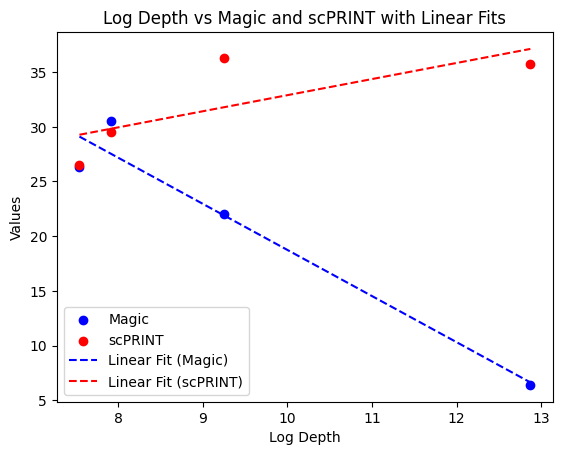

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Create a DataFrame
# from prevmodel
# data = {
#    'depth': [2736, 1888, 388362, 10360],
#    'magic': [30.4, 26.3, 6.4, 27.0],
#    'scprint': [19.3, 21.5, 33.2, 36.1]
# }
data = {
    "depth": [2736, 1888, 388362, 10360],
    "magic": [30.5, 26.3, 6.4, 22.0],
    "scprint": [29.5, 26.5, 35.7, 36.3],
}
df = pd.DataFrame(data)

# Convert depth to log scale
df["log_depth"] = np.log(df["depth"])


# Define a linear function for curve fitting
def linear_func(x, a, b):
    return a * x + b


# Fit the linear curves on log scale
popt_magic, _ = curve_fit(linear_func, df["log_depth"], df["magic"])
popt_scprint, _ = curve_fit(linear_func, df["log_depth"], df["scprint"])

# Plot the data points
plt.scatter(df["log_depth"], df["magic"], label="Magic", color="blue")
plt.scatter(df["log_depth"], df["scprint"], label="scPRINT", color="red")

# Plot the fitted linear curves
x_values = np.linspace(min(df["log_depth"]), max(df["log_depth"]), 100)
plt.plot(
    x_values,
    linear_func(x_values, *popt_magic),
    label="Linear Fit (Magic)",
    color="blue",
    linestyle="--",
)
plt.plot(
    x_values,
    linear_func(x_values, *popt_scprint),
    label="Linear Fit (scPRINT)",
    color="red",
    linestyle="--",
)

# Add labels and legend
plt.xlabel("Log Depth")
plt.ylabel("Values")
plt.legend()
plt.title("Log Depth vs Magic and scPRINT with Linear Fits")
plt.show()

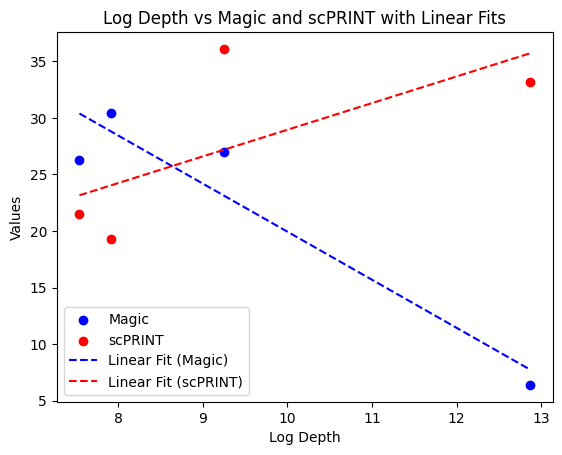

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Create a DataFrame
# from prevmodel
# data = {
#    'depth': [2736, 1888, 388362, 10360],
#    'magic': [30.4, 26.3, 6.4, 27.0],
#    'scprint': [19.3, 21.5, 33.2, 36.1]
# }
data = {
    "depth": [2736, 1888, 388362, 10360],
    "magic": [30.5, 26.3, 6.4, 22.0],
    "scprint": [29.5, 26.5, 35.7, 36.3],
}
df = pd.DataFrame(data)

# Convert depth to log scale
df["log_depth"] = np.log(df["depth"])


# Define a linear function for curve fitting
def linear_func(x, a, b):
    return a * x + b


# Fit the linear curves on log scale
popt_magic, _ = curve_fit(linear_func, df["log_depth"], df["magic"])
popt_scprint, _ = curve_fit(linear_func, df["log_depth"], df["scprint"])

# Plot the data points
plt.scatter(df["log_depth"], df["magic"], label="Magic", color="blue")
plt.scatter(df["log_depth"], df["scprint"], label="scPRINT", color="red")

# Plot the fitted linear curves
x_values = np.linspace(min(df["log_depth"]), max(df["log_depth"]), 100)
plt.plot(
    x_values,
    linear_func(x_values, *popt_magic),
    label="Linear Fit (Magic)",
    color="blue",
    linestyle="--",
)
plt.plot(
    x_values,
    linear_func(x_values, *popt_scprint),
    label="Linear Fit (scPRINT)",
    color="red",
    linestyle="--",
)

# Add labels and legend
plt.xlabel("Log Depth")
plt.ylabel("Values")
plt.legend()
plt.title("Log Depth vs Magic and scPRINT with Linear Fits")
plt.show()


In [ ]:
adata = sc.read(LOC + "lung_smart" + ".h5ad")

In [ ]:
preprocessor = Preprocessor(
    force_preprocess=True, skip_validate=True, drop_non_primary=False, do_postp=False
)
preprocessor = Preprocessor(do_postp=False)
adata = preprocessor(adata)
adata.layers["true"] = adata.X.copy()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 9409 renamining
filtered out 0 cells, 9409 renamining
Removed 129 genes not known to the ontology
Removed 0 duplicate genes
Added 16325 genes in the ontology but not present in the dataset
validating


/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata, organism=adata.obs.organism_ontology_term_id[0], need_all=False


starting QC
Seeing 5471 outliers (58.14% of total dataset):
done
AnnData object with n_obs × n_vars = 9409 × 70611
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'obs

In [37]:
denoise = Denoiser(
    batch_size=40 if adata.X.sum(1).mean() < 50_000 else 20,
    max_len=8_000,
    max_cells=100_000,
    doplot=False,
    num_workers=8,
    predict_depth_mult=5,
    downsample_expr=0.7,
)

In [40]:
_, idx, nadata = denoise(model, adata)

working on 4294 accepted genes
not on wandb, could not set name


100%|██████████| 471/471 [01:21<00:00,  5.81it/s]


logging the anndata
AnnData object with n_obs × n_vars = 9409 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


In [ ]:
nadata = nadata[:, nadata.var.index.isin(adata.var.index)]
adata = adata[:, adata.var.index.isin(nadata.var.index)]

In [ ]:
# Get min and max from adata
adata_min = np.array([1] * adata.X.shape[0])
adata_max = adata.X.max(1).data

# Get min and max for each row in nadata
nadata_min = nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1).min(axis=1)
nadata_max = nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1).max(axis=1)

# Rescale each row to match adata range
# Reshape the min/max arrays to match the matrix dimensions for broadcasting
nadata_min = nadata_min.reshape(-1, 1)
nadata_max = nadata_max.reshape(-1, 1)
adata_min = adata_min.reshape(-1, 1)
adata_max = adata_max.reshape(-1, 1)

# Perform the rescaling with properly shaped arrays
nadata.layers["scprint_mu"].data = (
    (nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1) - nadata_min)
    / (nadata_max - nadata_min)
    * (adata_max - adata_min)
    + adata_min
).flatten()


In [ ]:
# Create a mask for where scprint_mu is 0
zero_mask = nadata.layers["scprint_mu"] == 0
# Replace zeros with corresponding values from adata.X
nadata.layers["scprint_mu"][zero_mask] = adata.X[zero_mask]


/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3672: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
nadata.obs["cell_type"] = adata.obs["cell_type"].tolist()

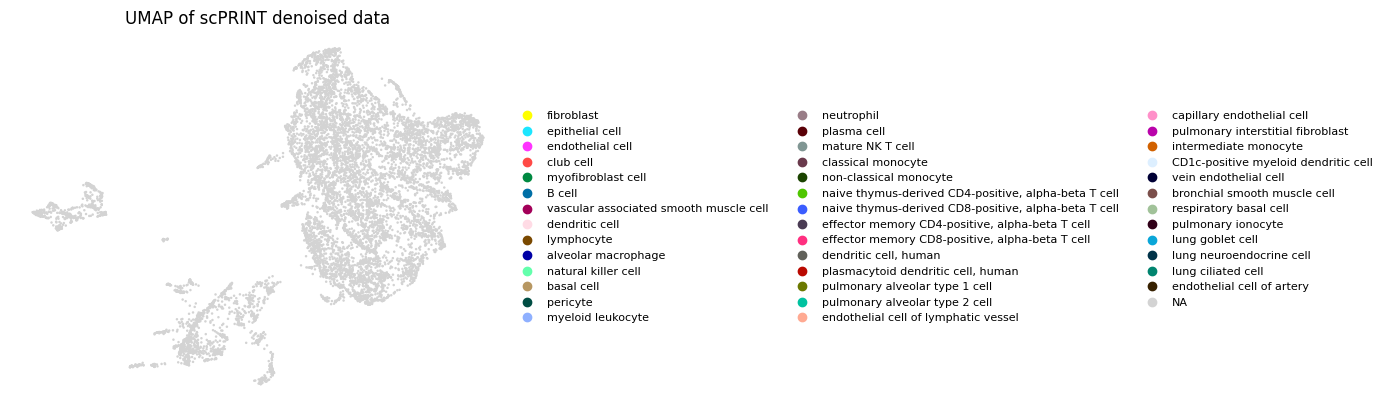

In [ ]:
# Create UMAP visualization of scprint_mu layer
import scanpy as sc

# Compute UMAP
# Compute PCA first
sc.pp.pca(nadata, layer="scprint_mu", n_comps=40)

sc.pp.neighbors(nadata, use_rep="X_pca", n_neighbors=15)
sc.tl.umap(nadata, n_components=2, min_dist=0.2, spread=1.5)
nadata.obs["cell_type"] = adata.obs["cell_type"].tolist()

# Plot UMAP colored by cell type
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)


... storing 'cell_type' as categorical


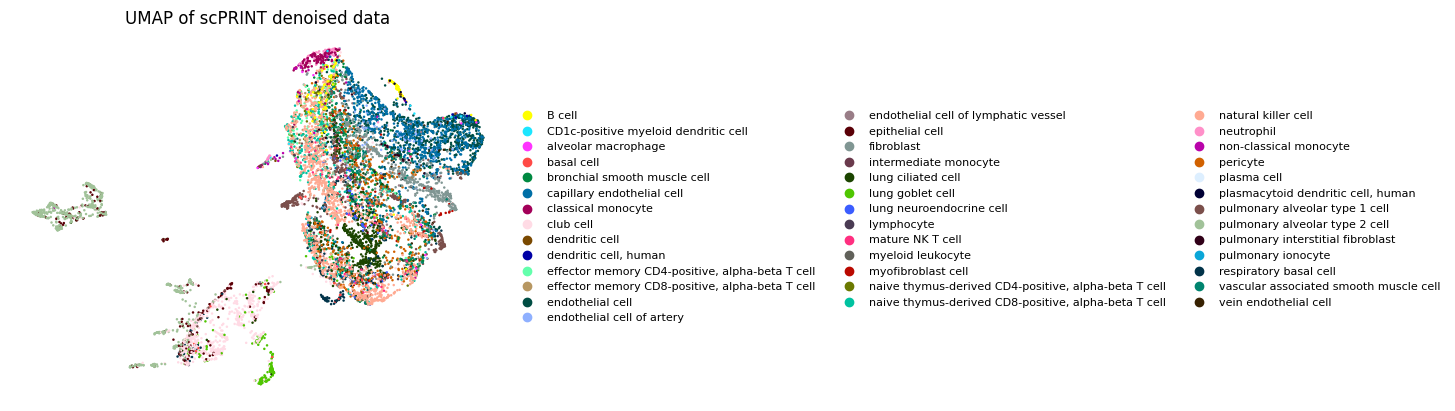

In [ ]:
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)

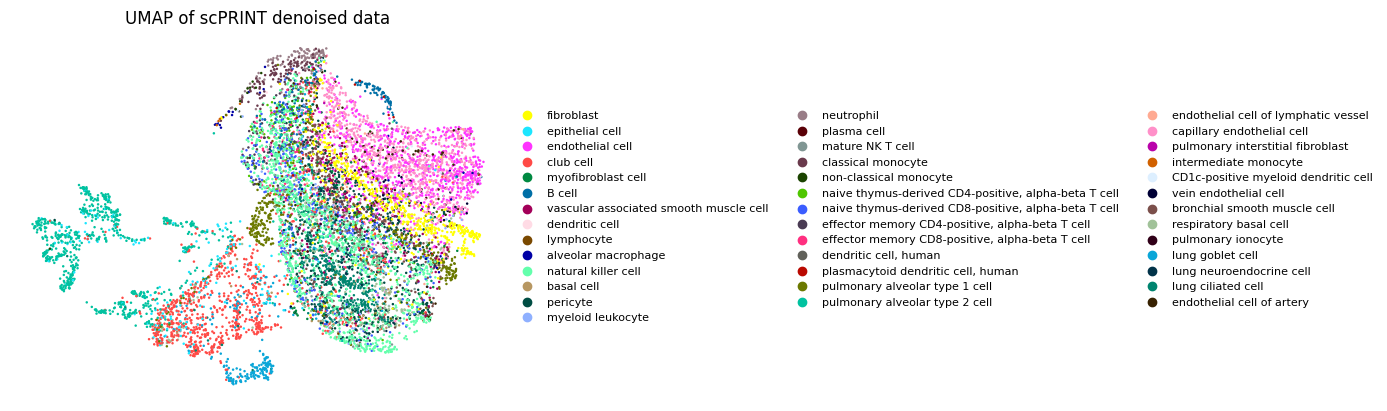

In [ ]:
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)

In [31]:
adata.X = downsample_profile(torch.Tensor(adata.X.toarray()), 0.7).numpy()

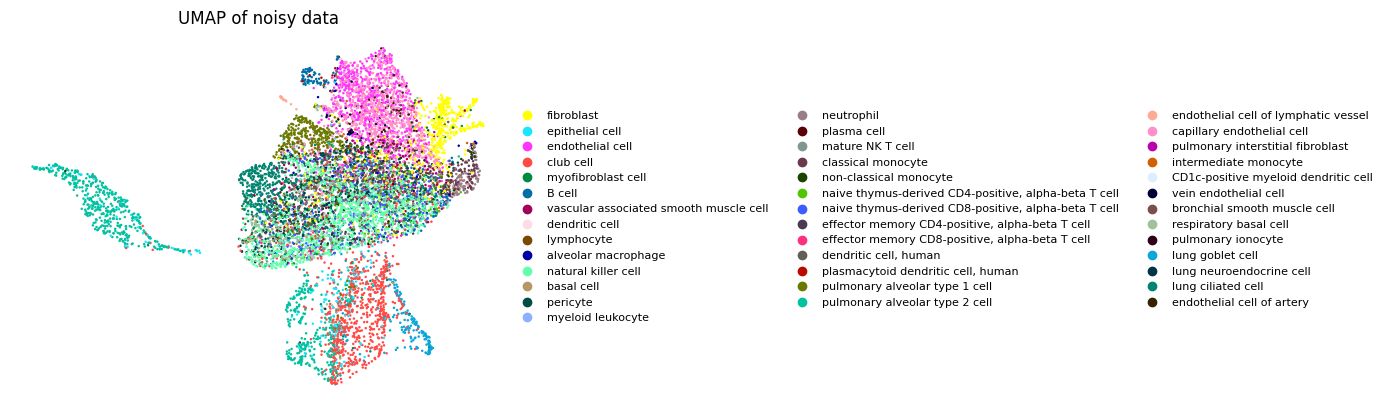

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(
    adata,
    color="cell_type",
    title="UMAP of noisy data",
    frameon=False,
    legend_fontsize=8,
    palette=nadata.uns["cell_type_colors"],
)

In [53]:
adata

AnnData object with n_obs × n_vars = 9409 × 23142
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n

In [ ]:
adata.layers["true"].sum(1).mean(), adata.X.sum(1).mean()

(979685.5, 370609.75)

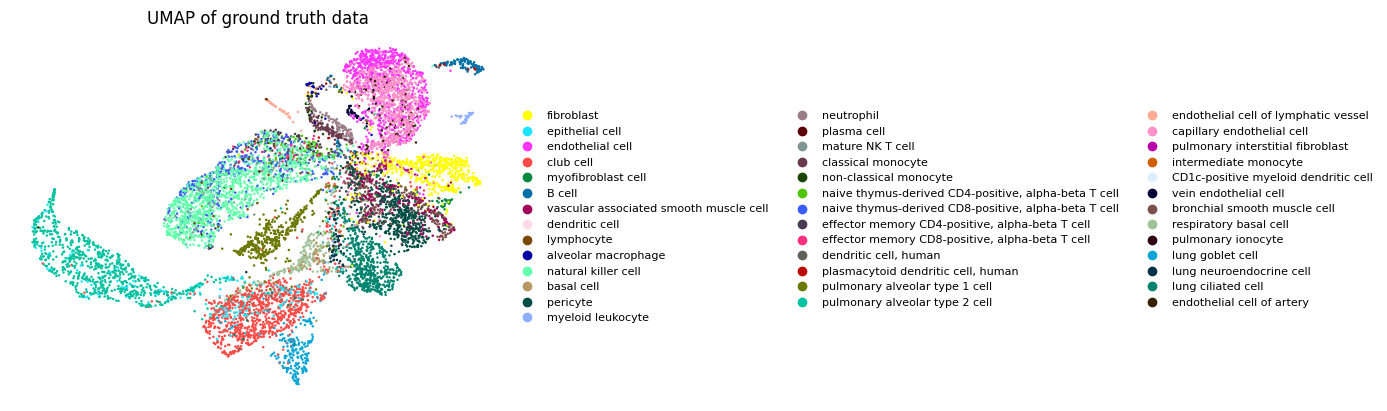

In [ ]:
adata.obsm["X_pca"] = sc.pp.pca(adata.layers["true"])
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(
    adata,
    color="cell_type",
    title="UMAP of ground truth data",
    frameon=False,
    legend_fontsize=8,
    palette=nadata.uns["cell_type_colors"],
)

In [ ]:
scprint vs magic (full vs rare)
33.6 vs 37.7 - 28.2 vs 26.4
30 vs 20 - 28.5 vs 17.5
22.3 vs 23.5 - 23.4 vs 5.0

## with MAGIC rare cells

In [ ]:
ct = "pericyte"
subadata.obs.cell_type.value_counts()
# microglial cell, microfold cell of epithelium of small intestine, mesangial cell, pericyte

cell_type
pigmented ciliary epithelial cell        13383
non-pigmented ciliary epithelial cell     4687
ciliary muscle cell                       3776
fibroblast                                3271
Schwann cell                              1778
macrophage                                1473
melanocyte                                1169
lymphocyte                                 222
blood vessel endothelial cell              149
pericyte                                    92
Name: count, dtype: int64

In [ ]:
reco = denoised_adata[subadata.obs.cell_type == ct].X
true = subadata[subadata.obs.cell_type == ct].layers["true"].toarray()
noisy = subadata[subadata.obs.cell_type == ct].X
corr_coef, p_value = spearmanr(
    np.vstack([reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.14750170131134832,
 'reco2full': 0.38880325415511774,
 'noisy2full': 0.3443993707013129}

## scPRINT rare cells

In [ ]:
denoise = Denoiser(
    batch_size=40,
    max_len=5000,
    max_cells=200,
    doplot=False,
    predict_depth_mult=6,
    downsample=0.7,
    how="most var",
)
metrics, idx, genes, expr = denoise(model, adata[adata.obs.cell_type == ct])
metrics

/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


{'reco2noisy': 0.3439042832146162,
 'reco2full': 0.5496913631860156,
 'noisy2full': 0.31487289773608945}